<a href="https://colab.research.google.com/github/hjeon2k/2021_InternshipOEN/blob/main/2021_OEN_LtoT_300-300-300-300_0.1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
!pip3 install 'gast==0.3.3'
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
fX = '/content/drive/My Drive/Colab Notebooks/2021_OEN/savex.csv'
fy = '/content/drive/My Drive/Colab Notebooks/2021_OEN/savey.csv'
X = pd.read_csv(fX)
y = pd.read_csv(fy)
print(X.shape, y.shape)
X.head()

(50000, 8) (50000, 201)


,# L1_1,L1_2,L2_1,L2_2,L3_1,L3_2,L4_1,L4_2
0,119.0,78.0,97.0,107.0,54.0,150.0,102.0,82.0
1,95.0,91.0,41.0,101.0,40.0,42.0,73.0,122.0
2,69.0,188.0,127.0,165.0,117.0,132.0,96.0,181.0
3,91.0,98.0,87.0,52.0,80.0,68.0,88.0,161.0
4,82.0,105.0,140.0,141.0,99.0,78.0,43.0,162.0


In [29]:
features_num = list(X.columns)
preprocessor = make_column_transformer((MinMaxScaler(), features_num),)

X = X.apply(lambda x: (x-40)/160)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

input_shape = [X_train.shape[1]]

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)

Minimum Validation Loss: 0.0263


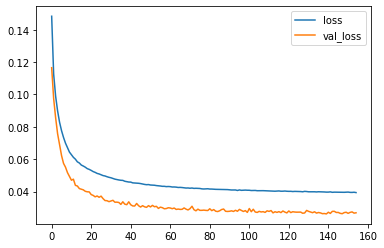

In [30]:
model = keras.Sequential([
    layers.Dense(300, activation='relu', input_shape=input_shape),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(201)
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [31]:
model.save("4L_model", save_format='tf')
load_model = keras.models.load_model("4L_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 4L_model/assets


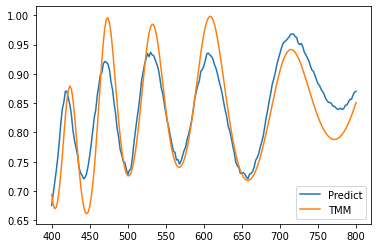

In [34]:
Points = 201
Lambda = np.linspace(400, 800, Points)

test_input = (np.array([180, 128, 160, 164, 191, 115, 160, 163]).reshape(1, 4*2) - 40) / 160#.astype(np.float32)
predict =  load_model.predict(test_input)
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/2021_OEN/test.csv')

plt.plot(Lambda, predict.reshape(Points,), label='Predict')
plt.plot(Lambda, np.array(test['# T']), label='TMM')
plt.legend()